# Historical analysis of geomagnetic variations in Austria

This code takes the last 26 years of geomagnetic field measurements from the Fürstenfeldbruck geomagnetic observatory and uses them as a proxy for geomagnetic variations in Austria, specifically at the Conrad Observatory.

### Contents
1. **Load geomagnetic, geoelectric, and GIC data**: Read geomagnetic observatory data from Fürstenfeldbruck (FUR) and the Conrad Observatory (WIC) for the years 1995 till 2020. Also plots all data throughout the years for comparison.
3. **Histograms and active days**: Plot the histogram distributions of different variables, then check out the most active days in the tail ends of these distributions.
4. **Case study: 2003 Halloween Storm**: Study of the 2003 Halloween storm using FUR minute data.

### Input and Output
- Input files were created using the 1_DataPreparation notebook.
- Plots are saved to plots/.

**Author**: Rachel L. Bailey (ZAMG, r.bailey@zamg.ac.at), Dec 2020 - Aug 2021.

In [1]:
import os, sys
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num, DateFormatter
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import time

import seaborn as sns
from sklearn.metrics import mean_squared_error

import sw2gic

## 1. Load geomagnetic, geoelectric, and GIC data

This analysis uses data from two geomagnetic observatories: 
- Fürstenfeldbruck (FUR) in Bavaria, Germany (years 1995-2020),
- the Conrad Observatory (WIC) in Austria (years 2016-2020).

These datasets were downloaded from INTERMAGNET: https://intermagnet.org/data-donnee/download-eng.php

In [2]:
# Local parameters:
with open('parameters.json', 'r') as fp:
    Params = json.load(fp)
# Data save paths
data_path = Params['datapath']
plot_path = Params['plotpath']
readyears_FUR = [1995, 2021]
readyears_WIC = [2015, 2021]

### Read FUR data

In [3]:
pickled_data_path = os.path.join(data_path, "all_fur_data_clean.p")
df_FUR = pd.read_pickle(pickled_data_path)
df_FUR

,Bx,By,Bz,F,Data_Gap,dBx/dt,dBy/dt,dBz/dt
time,,,,,,,,
1995-01-01 00:00:00,20821.00,151.00,42843.00,47634.645910,False,0.00,0.00,0.00
1995-01-01 00:01:00,20821.00,151.00,42843.00,47634.645910,False,0.00,0.00,0.00
1995-01-01 00:02:00,20821.00,151.00,42843.00,47634.645910,False,0.00,0.00,0.00
1995-01-01 00:03:00,20821.00,151.00,42843.00,47634.645910,False,0.00,0.00,0.00
1995-01-01 00:04:00,20821.00,150.00,42843.00,47634.642751,False,0.00,-1.00,0.00
...,...,...,...,...,...,...,...,...
2020-12-31 23:55:00,20987.26,1315.00,43738.01,48530.483472,False,0.15,0.06,0.00
2020-12-31 23:56:00,20986.84,1315.16,43738.05,48530.342228,False,-0.42,0.16,0.04
2020-12-31 23:57:00,20986.84,1315.01,43738.09,48530.374214,False,0.00,-0.15,0.04


### Read WIC data

In [4]:
pickled_data_path = os.path.join(data_path, "all_wic_data_clean.p")
df_WIC = pd.read_pickle(pickled_data_path)
df_WIC

,Bx,By,Bz,F,Data_Gap,dBx/dt,dBy/dt,dBz/dt
time,,,,,,,,
2015-01-01 00:00:00,20989.40,1377.00,43659.10,48462.026930,False,0.00,0.00,0.00
2015-01-01 00:01:00,20989.40,1376.80,43659.20,48462.111337,False,0.00,-0.20,0.10
2015-01-01 00:02:00,20989.50,1376.50,43659.20,48462.146126,False,0.10,-0.30,0.00
2015-01-01 00:03:00,20989.40,1376.20,43659.30,48462.184384,False,-0.10,-0.30,0.10
2015-01-01 00:04:00,20989.40,1376.00,43659.30,48462.178705,False,0.00,-0.20,0.00
...,...,...,...,...,...,...,...,...
2020-12-31 23:55:00,21005.85,1690.65,43969.45,48758.758854,False,0.13,0.08,-0.01
2020-12-31 23:56:00,21005.51,1690.79,43969.47,48758.635269,False,-0.34,0.14,0.02
2020-12-31 23:57:00,21005.52,1690.64,43969.48,48758.643393,False,0.01,-0.15,0.01


### Plot WIC and FUR data

This can be skipped to go straight to the data analysis in part 2.

In [5]:
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)

c_fur = 'teal'
c_wic = 'k'
n_mins_in_year = 365. * 24. * 60.
sns.set_style("ticks")
skip = 60

#### Plots of FUR

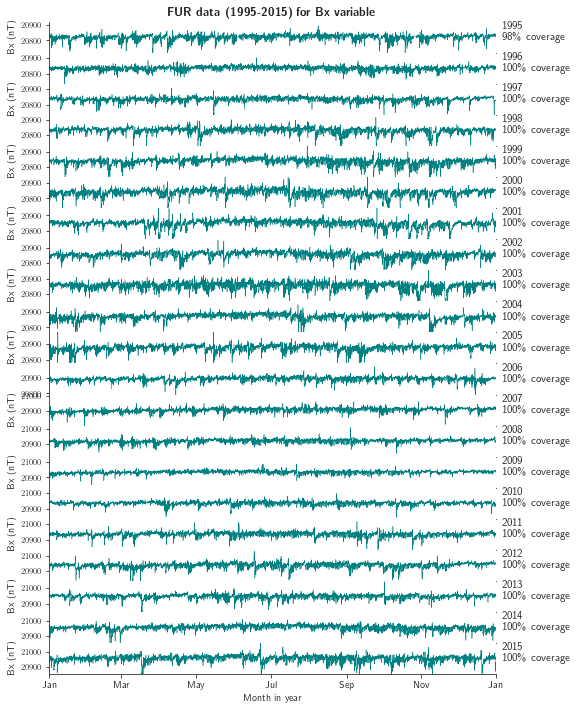

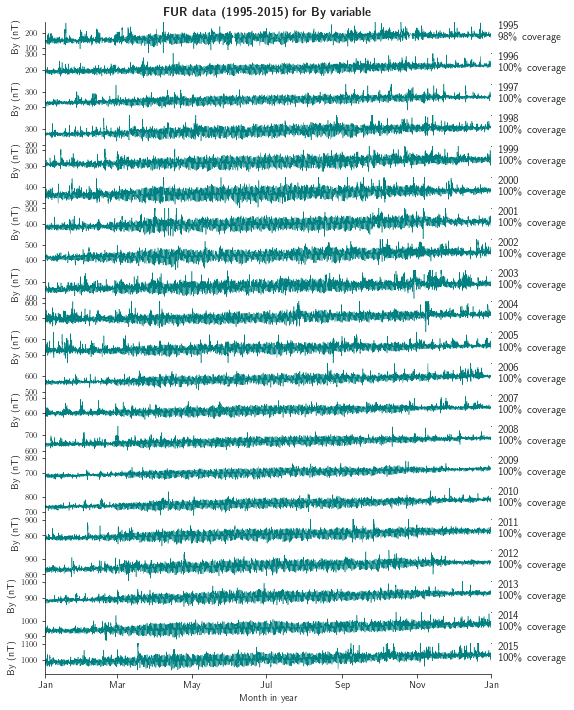

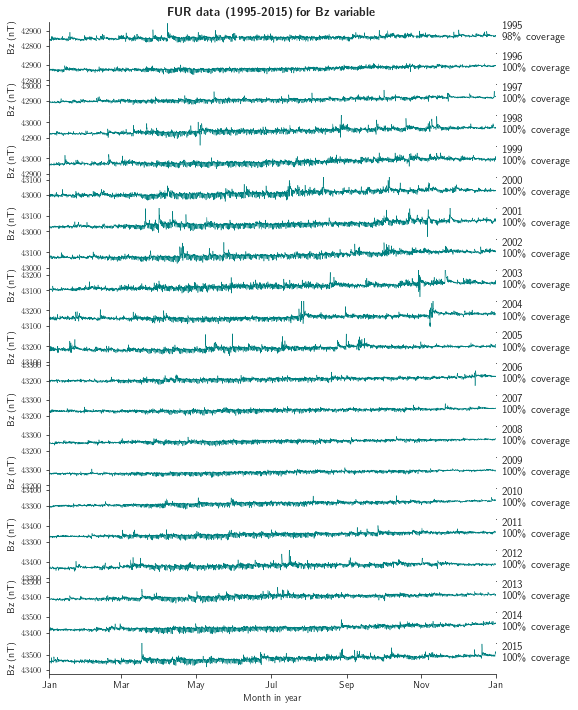

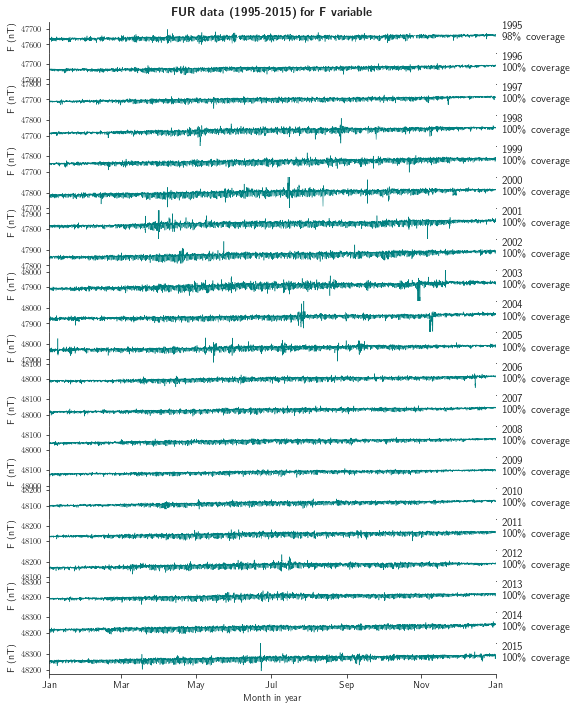

In [6]:
plotyears = range(1995,2016)

for plot_var in ['Bx', 'By', 'Bz', 'F']:
    fig, axes = plt.subplots(len(plotyears), 1, figsize=(8,12))
    for iyear, plotyear in enumerate(plotyears):
        start_year, end_year = datetime(plotyear,1,1), datetime(plotyear+1,1,1)

        # Extract data
        fur_year = np.array(df_FUR[start_year:end_year][plot_var])
        times_fur_year = np.array(df_FUR[start_year:end_year].index)
        perc_of_year_shared = len(times_fur_year) / n_mins_in_year * 100.

        # Plot
        axes[iyear].plot_date(times_fur_year[::skip], fur_year[::skip], '-', c=c_fur, lw=0.5, label='FUR')
        axes[iyear].set_xlim((datetime(plotyear,1,1), datetime(plotyear+1,1,1)))
        axes[iyear].set_ylim((np.mean(fur_year)-100, np.mean(fur_year)+100))

        if plotyear != plotyears[-1]:
            axes[iyear].set_xticks([])
        if iyear % 2 == 0:
            axes[iyear].set_ylabel("{} (nT)".format(plot_var))
        for tick in axes[iyear].yaxis.get_major_ticks():
            tick.label.set_fontsize(8) 
        axes[iyear].grid(False)
        axes[iyear].text(1.015, 0.4, "{}\n{:.0f}\% coverage".format(str(plotyear), perc_of_year_shared), 
                         transform=axes[iyear].transAxes, fontsize=11)
    axes[-1].xaxis.set_major_formatter(DateFormatter("%b"))
    axes[-1].set_xlabel("Month in year")
    title_text = "FUR data ({}-{}) for {} variable".format(plotyears[0], plotyears[-1], plot_var)
    axes[0].set_title(r"$\textbf{"+title_text+"}$")
    sns.despine()
    plt.subplots_adjust(hspace=0.)
    #plt.savefig("plots/{}_all_years.pdf".format(plot_var))
    plt.savefig(os.path.join(plot_path,"fur_{}_allyears.png".format(plot_var)), dpi=200, bbox_inches='tight')
    plt.show()

#### Plots of WIC vs. FUR

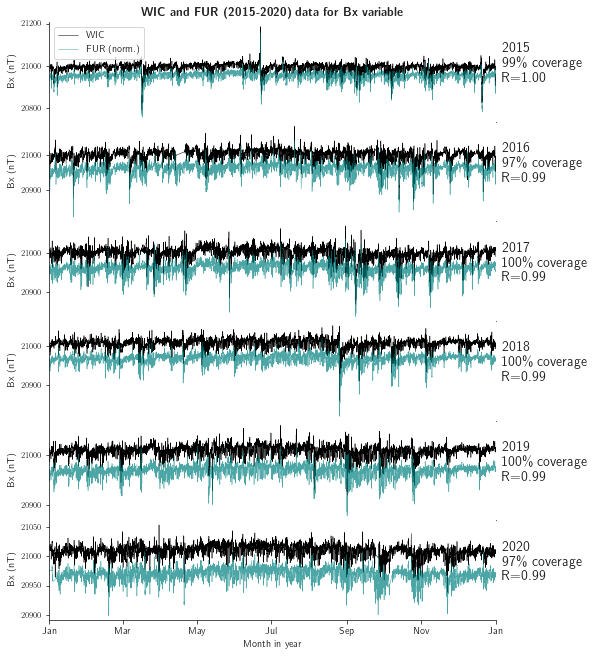

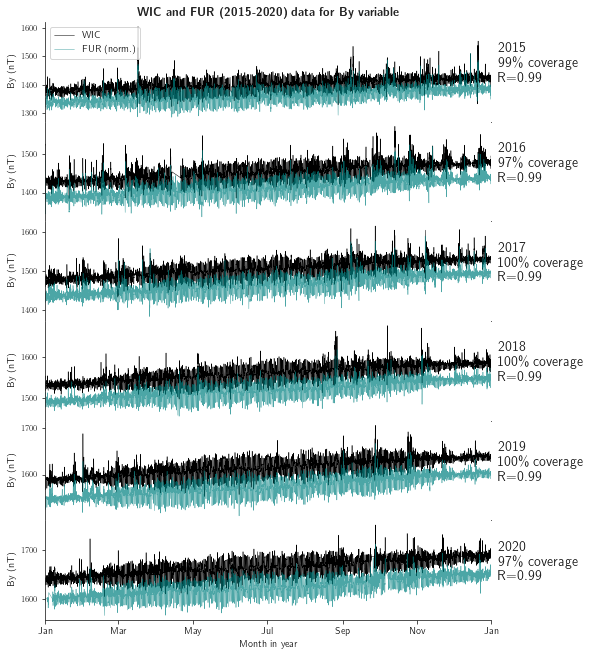

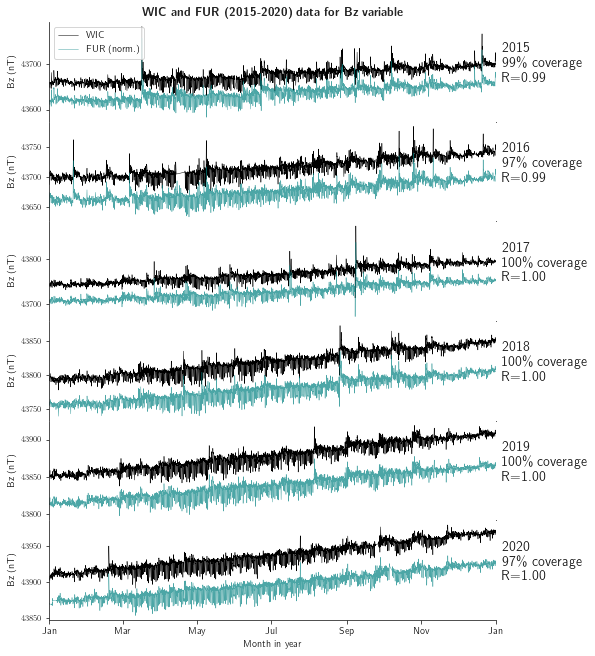

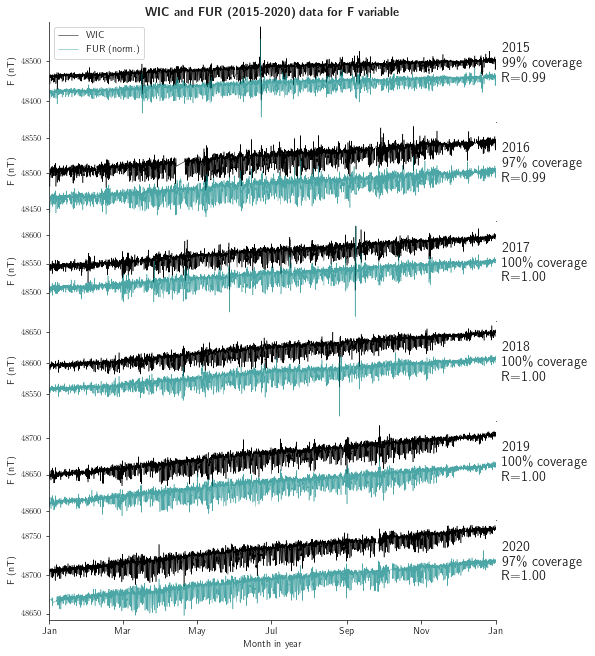

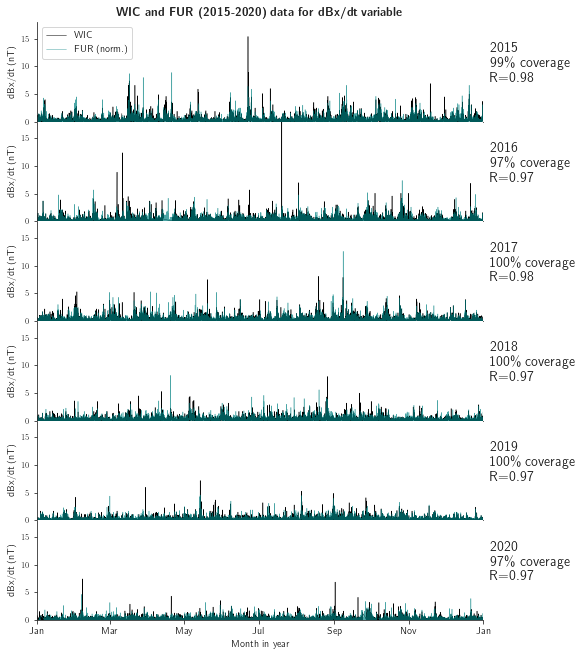

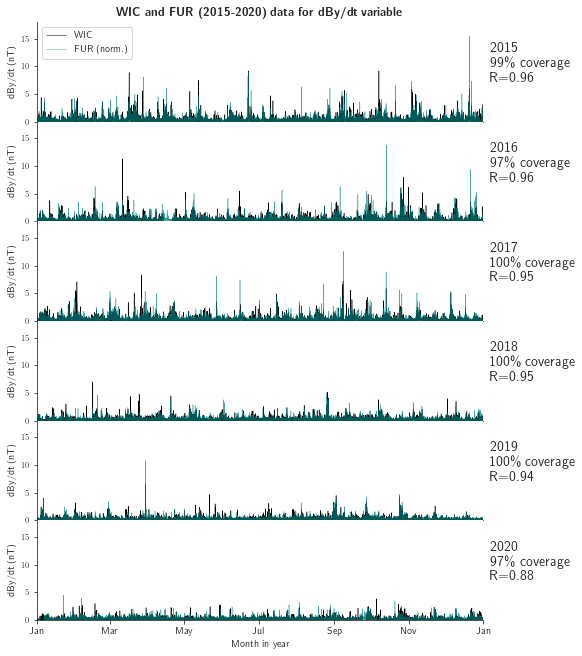

In [7]:
plotyears = range(2015,2021)

for plot_var in ['Bx', 'By', 'Bz', 'F', 'dBx/dt', 'dBy/dt']:
    fig, axes = plt.subplots(len(plotyears), 1, figsize=(8,11))
    for iyear, plotyear in enumerate(plotyears):
        start_year, end_year = datetime(plotyear,1,1), datetime(plotyear+1,1,1)

        # Extract data
        wic_year = np.array(df_WIC[start_year:end_year][plot_var])
        fur_year = np.array(df_FUR[start_year:end_year][plot_var])
        if 'dt' not in plot_var:
            fur_year = fur_year - np.mean(fur_year) + (np.mean(wic_year) - 40)
        else:
            wic_year, fur_year = np.abs(wic_year), np.abs(fur_year)
        times_wic_year = np.array(df_WIC[start_year:end_year].index)
        times_fur_year = np.array(df_FUR[start_year:end_year].index)
        shared_inds = np.intersect1d(times_fur_year, times_wic_year)
        perc_of_year_shared = len(shared_inds) / n_mins_in_year * 100.

        # Calculate correlation between them:
        shared_wic_year = df_WIC.loc[shared_inds, plot_var]
        shared_fur_year = df_FUR.loc[shared_inds, plot_var]
        ppmcc = pearsonr(shared_wic_year, shared_fur_year)[0]

        # Plot
        axes[iyear].plot_date(times_wic_year[::skip], wic_year[::skip], '-', c=c_wic, lw=0.5, label='WIC')
        axes[iyear].plot_date(times_fur_year[::skip], fur_year[::skip], '-', c=c_fur, lw=0.5, label='FUR (norm.)', alpha=0.7)
        axes[iyear].set_xlim((datetime(plotyear,1,1), datetime(plotyear+1,1,1)))
        if '/dt' in plot_var:
            axes[iyear].set_ylim((0., 18.))

        if plotyear != plotyears[-1]:
            axes[iyear].set_xticks([])
        #if iyear == int(len(plotyears)/2.):
        axes[iyear].set_ylabel("{} (nT)".format(plot_var))
        for tick in axes[iyear].yaxis.get_major_ticks():
            tick.label.set_fontsize(8) 
        axes[iyear].grid(False)
        axes[iyear].text(1.015, 0.4, "{}\n{:.0f}\% coverage\nR={:.2f}".format(str(plotyear), perc_of_year_shared, ppmcc), 
                         transform=axes[iyear].transAxes, fontsize=14)
    axes[-1].xaxis.set_major_formatter(DateFormatter("%b"))
    axes[-1].set_xlabel("Month in year")
    axes[0].legend(loc='upper left')
    title_text = "WIC and FUR ({}-{}) data for {} variable".format(plotyears[0], plotyears[-1], plot_var)
    axes[0].set_title(r"$\textbf{"+title_text+"}$")
    sns.despine()
    plt.subplots_adjust(hspace=0.)
    #plt.savefig("plots/{}_all_years.pdf".format(plot_var))
    plt.savefig(os.path.join(plot_path, "fur-wic_{}_cut.png".format(plot_var.replace('/',''))), dpi=200, bbox_inches='tight')
    plt.show()

#### Check if there is any scaling effect between the two stations

It seems there isn't.

0.965059922797115
y = 0.975*x
0.870627605174882
y = 1.035*x


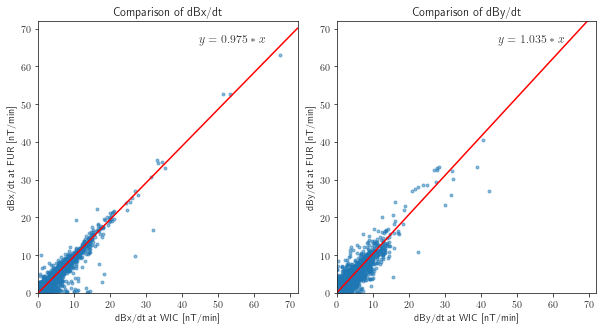

In [8]:
def line(x, a):
    return a * x

plot_lim = 72.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
for plot_var, ax in zip(['dBx/dt', 'dBy/dt'], [ax1, ax2]):
    start_year, end_year = datetime(2015,1,1), datetime(2020,1,1)

    # Extract data
    wic_year = np.array(df_WIC[start_year:end_year][plot_var])
    fur_year = np.array(df_FUR[start_year:end_year][plot_var])
    if 'dt' not in plot_var:
        fur_year = fur_year - np.mean(fur_year) + (np.mean(wic_year) - 40)
    times_wic_year = np.array(df_WIC[start_year:end_year].index)
    times_fur_year = np.array(df_FUR[start_year:end_year].index)
    shared_inds = np.intersect1d(times_fur_year, times_wic_year)
    perc_of_year_shared = len(shared_inds) / n_mins_in_year * 100.

    # Calculate correlation between them:
    shared_wic_year = np.abs(df_WIC.loc[shared_inds, plot_var])
    shared_fur_year = np.abs(df_FUR.loc[shared_inds, plot_var])
    ppmcc = pearsonr(shared_wic_year[shared_fur_year > 10], shared_fur_year[shared_fur_year > 10])[0]
    print(ppmcc)
    
    # Fit a line to the data:
    popt, pcov = curve_fit(line, shared_wic_year[shared_fur_year > 10], shared_fur_year[shared_fur_year > 10])
    xfit = np.linspace(0, plot_lim, 100)
    y  = line(xfit, popt[0])
    fit_str = "y = {:.3f}*x".format(popt[0])
    print(fit_str)

    ax.plot(shared_wic_year, shared_fur_year, '.', alpha=0.5)
    ax.plot(xfit, y, 'r-')
    ax.text(0.62, 0.92, r"$"+fit_str+"$", transform=ax.transAxes, fontsize=12)
    ax.set_xlabel("{} at WIC [nT/min]".format(plot_var))
    ax.set_ylabel("{} at FUR [nT/min]".format(plot_var))
    ax.set_title("Comparison of {}".format(plot_var))
    ax.set_xlim((0., plot_lim))
    ax.set_ylim((0., plot_lim))
plt.subplots_adjust(wspace=0.15)
plt.savefig(os.path.join(plot_path, "dbdt-fit.png"), dpi=300, bbox_inches='tight')
plt.show()

### E-field from FUR data

In [9]:
all_efield_path = os.path.join(data_path, "efield_fur_39_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
print("Loading pre-calculated E-field...")
E_t = np.load(all_efield_path)
print("    Number of data points: {}".format(len(E_t[0])))
print("Done.")

Loading pre-calculated E-field...
    Number of data points: 13675680
Done.


In [10]:
# Some numbers:
print("Max. abs. Ex in data: {:.1f} mV/km".format(np.max(np.abs(E_t[0]))))
print("Max. abs. Ey in data: {:.1f} mV/km".format(np.max(np.abs(E_t[1]))))
print("Max. abs. E in data:  {:.1f} mV/km".format(np.max(np.abs(np.sqrt(E_t[0]**2 + E_t[1]**2)))))

Max. abs. Ex in data: 439.2 mV/km
Max. abs. Ey in data: 560.1 mV/km
Max. abs. E in data:  647.4 mV/km


### E-field from WIC data

In [11]:
wic_efield_path = os.path.join(data_path, "efield_wic_39_{}-{}.txt".format(readyears_WIC[0], readyears_WIC[1]))
print("Loading pre-calculated E-field...")
E_t_WIC = np.load(wic_efield_path)
print("    Number of data points: {}".format(len(E_t_WIC[0])))
print("Done.")

Loading pre-calculated E-field...
    Number of data points: 3156480
Done.


### GIC fits for two stations

In [12]:
df_features_gic = pd.read_pickle(os.path.join(data_path, 'df_features_gic.p'))
gic_fit_SS1 = df_features_gic['GIC_fit_SS1'].to_numpy()
gic_fit_SS2 = df_features_gic['GIC_fit_SS2'].to_numpy()

## 2. Histograms and active days

Plot the histogram distributions of different variables:
1. dB/dt in both _x_ and _y_ components.
2. The GIC values in two stations.

Then check out the most active days in the tail ends of these distributions.

### Histogram plots

In [13]:
%matplotlib inline
sns.set_style(Params["sns_style"])
hist_figsize = (10,4)

c_SS1, c_SS2 = Params['c_SS1'], Params['c_SS2']

from matplotlib import rc
rc('text', usetex=True)

#### Cumulative GIC values

In [14]:
zero_time = pd.to_datetime(df_FUR.index[0])

In [47]:
from scipy import integrate
# Calculate the cumulative sum over certain periods:
window_len = 60
inds_sums, gic_SS1_sums, gic_SS2_sums, t_sums = [], [], [], []
cut1, cut2 = 0, 60
while cut2 < len(gic_fit_SS1):
    cut2 = cut1 + window_len
    gic_SS1_sums.append(integrate.trapz(np.abs(gic_fit_SS1[cut1:cut2])))
    gic_SS2_sums.append(integrate.trapz(np.abs(gic_fit_SS2[cut1:cut2])))
    t_sums.append(zero_time + timedelta(minutes=int(cut1+window_len/2)))
    inds_sums.append(cut1 + window_len/2.)
    cut1 += window_len
inds_sums, gic_SS1_sums, gic_SS2_sums = np.array(inds_sums), np.array(gic_SS1_sums), np.array(gic_SS2_sums)
t_sums = np.array(t_sums)

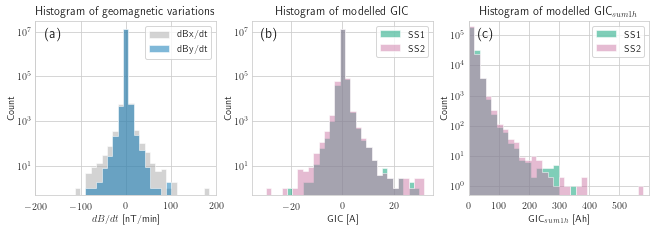

In [16]:
fig, (ax_db, ax_gic, ax_sum) = plt.subplots(1,3, figsize=(11,3.2))
nbins = 31 #51
fc_hist1 = '#1E88E5'
fc_hist = '#FFA107'
c_Bx, c_By = "darkgrey", "#0072b2"
fc_alpha, fc_alpha1 = 0.6, 0.8

dBx = df_FUR['dBx/dt'].to_numpy()
dBy = df_FUR['dBy/dt'].to_numpy()

# Geomagnetic variations
max_db = np.max([np.max(np.abs(dBx)),np.max(np.abs(dBx))])
sns.distplot(dBx, label='dBx/dt', color=c_Bx, bins=nbins, ax=ax_db, kde=False, hist_kws=dict(alpha=0.5, histtype="stepfilled", range=[-max_db, max_db]))
sns.distplot(dBy, label='dBy/dt', color=c_By, bins=nbins, ax=ax_db, kde=False, hist_kws=dict(alpha=0.5, histtype="stepfilled", range=[-max_db, max_db]))
ax_db.set_title("Histogram of geomagnetic variations")
ax_db.set_xlabel("$dB/dt$ [nT/min]")
ax_db.set_xlim(-200,200)

max_gic = np.max((np.abs(gic_fit_SS1).max(), np.abs(gic_fit_SS2).max()))
sns.distplot(gic_fit_SS1, label='SS1', color=c_SS1, bins=nbins, ax=ax_gic, kde=False, hist_kws=dict(alpha=0.5, histtype="stepfilled", range=[-max_gic, max_gic]))
sns.distplot(gic_fit_SS2, label='SS2', color=c_SS2, bins=nbins, ax=ax_gic, kde=False, hist_kws=dict(alpha=0.5, histtype="stepfilled", range=[-max_gic, max_gic]))
ax_gic.set_title(r'Histogram of modelled GIC')
ax_gic.set_xlabel(r"GIC [A]")

max_sum = np.max((np.abs(gic_SS1_sums).max(), np.abs(gic_SS2_sums).max()))
sns.distplot(gic_SS1_sums, label='SS1', color=c_SS1, bins=nbins, ax=ax_sum, kde=False, hist_kws=dict(alpha=0.5, histtype="stepfilled", range=[0, max_sum]))
sns.distplot(gic_SS2_sums, label='SS2', color=c_SS2, bins=nbins, ax=ax_sum, kde=False, hist_kws=dict(alpha=0.5, histtype="stepfilled", range=[0, max_sum]))
ax_sum.set_xlim([0, max_sum+20])
ax_sum.set_title(r'Histogram of modelled GIC$_{sum1h}$')
ax_sum.set_xlabel(r"GIC$_{sum1h}$ [Ah]")

for ax in (ax_db, ax_gic, ax_sum):
    ax.set_yscale('log')
    ax.set_ylabel("Count", labelpad=1)
    ax.legend()
    ax.tick_params(axis='y', pad=1)

max_count = 30000000
ax_db.set_ylim([0.5, max_count])
ax_gic.set_ylim([0.5, max_count])
ax_sum.set_ylim([0.5, max_count/100])

# Label each panel:
for ax, ann in zip([ax_db, ax_gic, ax_sum], ['a', 'b', 'c']):
    ax.text(0.05, 0.9, "("+ann+")", transform=ax.transAxes, fontsize=14)


plt.savefig(os.path.join(plot_path, "hist_all.png"), dpi=300, bbox_inches='tight')
plt.show()

### Find the days with maximum values

#### dBx/dt and dBy/dt

In [17]:
# List of days from max(db/dt)
# for the X-component
max_dbxdt_days = df_FUR[np.abs(df_FUR['dBx/dt']) > 50]['dBx/dt'].abs().sort_values(ascending=False)
max_dbxdt_datelist = []
for x in max_dbxdt_days.index:
    if str(x)[:10] not in max_dbxdt_datelist:
        max_dbxdt_datelist.append(str(x)[:10])
max_dbxdt_datelist = max_dbxdt_datelist[:10]
# for the Y-component
max_dbydt_days = df_FUR[np.abs(df_FUR['dBy/dt'] > 35)]['dBy/dt'].abs().sort_values(ascending=False)
max_dbydt_datelist = []
for x in max_dbydt_days.index:
    if str(x)[:10] not in max_dbydt_datelist:
        max_dbydt_datelist.append(str(x)[:10])
max_dbydt_datelist.remove('2020-10-20') # bad data
max_dbydt_datelist = max_dbydt_datelist[:10]
print(len(max_dbxdt_datelist), max_dbxdt_datelist)
print(len(max_dbydt_datelist), max_dbydt_datelist)

10 ['2000-07-15', '2003-10-29', '2003-10-31', '2001-11-24', '2001-11-06', '2001-03-31', '2004-07-26', '2004-11-09', '2005-09-11', '2015-06-22']
10 ['2003-10-29', '2003-10-31', '2004-11-09', '1998-05-04', '2000-04-06', '2001-03-31', '2003-10-30', '2001-11-06', '2004-11-07', '2005-05-15']


#### Absolute GIC values

In [18]:
sums_inds = np.where(np.abs(gic_fit_SS1) > 8)[0]
date_list_abs_SS1, max_list_abs_SS1 = [], []
for max_ind in sums_inds:
    max_time = zero_time + timedelta(minutes=int(max_ind))
    date_list_abs_SS1.append(str(max_time)[:10])
    max_list_abs_SS1.append(np.abs(gic_fit_SS1[int(max_ind)]))
max_gic_SS1 = pd.Series(max_list_abs_SS1, index=date_list_abs_SS1).sort_values(ascending=False)
    
sums_inds = np.where(np.abs(gic_fit_SS2) > 10)[0]
date_list_abs_SS2, max_list_abs_SS2 = [], []
for max_ind in sums_inds:
    max_time = zero_time + timedelta(minutes=int(max_ind))
    date_list_abs_SS2.append(str(max_time)[:10])
    max_list_abs_SS2.append(np.abs(gic_fit_SS2[int(max_ind)]))
max_gic_SS2 = pd.Series(max_list_abs_SS2, index=date_list_abs_SS2).sort_values(ascending=False)

In [19]:
# List of days from absolute GICs
# at SS1
max_SS1_datelist = []
for x in max_gic_SS1.index:
    if str(x)[:10] not in max_SS1_datelist:
        max_SS1_datelist.append(str(x)[:10])
max_SS1_datelist = max_SS1_datelist[:10]
# at SS2
max_SS2_datelist = []
for x in max_gic_SS2.index:
    if str(x)[:10] not in max_SS2_datelist:
        max_SS2_datelist.append(str(x)[:10])
max_SS2_datelist = max_SS2_datelist[:10]
print(len(max_SS1_datelist), max_SS1_datelist)
print(len(max_SS2_datelist), max_SS2_datelist)

10 ['2003-10-29', '2000-07-15', '2003-10-30', '2003-10-31', '2004-11-09', '2001-11-24', '2001-11-06', '2003-11-20', '2005-05-15', '1998-05-04']
10 ['2003-10-29', '2000-07-15', '2001-11-24', '2001-03-31', '2003-10-31', '2015-06-22', '2003-10-30', '2004-07-26', '2005-05-15', '2001-11-06']


#### Cumulative GIC values

In [33]:
sums_inds = np.where(gic_SS1_sums > 120)[0]
date_list_SS1, max_list_SS1 = [], []
for max_ind in sums_inds:
    num_of_mins = inds_sums[max_ind]
    max_time = zero_time + timedelta(minutes=int(num_of_mins))
    date_list_SS1.append(str(max_time)[:10])
    max_list_SS1.append(gic_SS1_sums[int(max_ind)])
max_gictot_SS1 = pd.Series(max_list_SS1, index=date_list_SS1).sort_values(ascending=False)
    
sums_inds = np.where(gic_SS2_sums > 150)[0]
date_list_SS2, max_list_SS2 = [], []
for max_ind in sums_inds:
    num_of_mins = inds_sums[max_ind]
    max_time = zero_time + timedelta(minutes=int(num_of_mins))
    date_list_SS2.append(str(max_time)[:10])
    max_list_SS2.append(gic_SS2_sums[int(max_ind)])
max_gictot_SS2 = pd.Series(max_list_SS2, index=date_list_SS2).sort_values(ascending=False)

In [34]:
# List of days from cumulative GICs
# at SS1
max_cumSS1_datelist = []
for x in max_gictot_SS1.index:
    if str(x)[:10] not in max_cumSS1_datelist:
        max_cumSS1_datelist.append(str(x)[:10])
max_cumSS1_datelist = max_cumSS1_datelist[:10]
# at SS2
max_cumSS2_datelist = []
for x in max_gictot_SS2.index:
    if str(x)[:10] not in max_cumSS2_datelist:
        max_cumSS2_datelist.append(str(x)[:10])
max_cumSS2_datelist = max_cumSS2_datelist[:10]
print(len(max_cumSS1_datelist), max_cumSS1_datelist)
print(len(max_cumSS2_datelist), max_cumSS2_datelist)

10 ['2003-10-29', '2003-11-20', '2000-07-15', '2003-10-30', '2001-11-24', '2005-05-15', '2004-11-09', '2000-09-17', '2004-11-08', '2005-08-24']
10 ['2003-10-29', '2005-05-15', '2000-07-15', '2005-08-24', '2001-11-06', '2003-10-30', '2003-11-20', '2000-09-17', '2001-11-24', '2003-10-31']


#### Make a LaTeX-friendly table of the dates

Paste into https://www.tablesgenerator.com/ ((n_days+1) x 7 grid) to finalise.

In [35]:
all_max_dates = list(set(max_SS2_datelist + max_SS1_datelist + max_cumSS2_datelist + max_cumSS1_datelist + max_dbxdt_datelist + max_dbydt_datelist))
print("n_days = {}".format(len(all_max_dates)))
all_max_dates.sort()
n_mins_day = int(60.*24.)
print("{}\t{}\t{}\t{}\t{}\t{}\t{}".format('Date', r'$dBx/dt$', r'$dBy/dt$', r'$GIC_{abs,SS1}$', r'$GIC_{abs,SS2}$', r'$GIC_{cum1h,SS1}$', r'$GIC_{cum1h,SS2}$'))
print("{}\t{}\t{}\t{}\t{}\t{}\t{}".format(' ', '[nT/min]', '[nT/min]', '[A]', '[A]', '[A]', '[A]'))
colstr = {}
all_max_vals = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for date in all_max_dates:
    date_dt = datetime.strptime(date, "%Y-%m-%d")
    n_min_diff = int((date_dt - zero_time).total_seconds()/60.)
    n_hour_diff = int(n_min_diff/60.)
    colstr[1] = '{:.1f}'.format(df_FUR.loc[date_dt:date_dt+timedelta(days=1), 'dBx/dt'].max())
    colstr[2] = '{:.1f}'.format(df_FUR.loc[date_dt:date_dt+timedelta(days=1), 'dBy/dt'].max())
    colstr[3] = '{:.2f}'.format(np.max(np.abs(gic_fit_SS1[n_min_diff:n_min_diff+n_mins_day])))
    colstr[4] = '{:.2f}'.format(np.max(np.abs(gic_fit_SS2[n_min_diff:n_min_diff+n_mins_day])))
    colstr[5] = '{:.1f}'.format(np.max(np.abs(gic_SS1_sums[n_hour_diff:n_hour_diff+24])))
    colstr[6] = '{:.1f}'.format(np.max(np.abs(gic_SS2_sums[n_hour_diff:n_hour_diff+24])))
    for colnum, datelist in zip(range(1,7),
                                [max_dbxdt_datelist, max_dbydt_datelist, max_SS1_datelist, 
                                 max_SS2_datelist, max_cumSS1_datelist, max_cumSS2_datelist]):
        if date in datelist:
            colstr[colnum] = r'\textbf{'+colstr[colnum]+'}'
        all_max_vals[colnum].append(float(colstr[colnum].replace('\\textbf{', '').replace('}','')))
    print("{}\t{}\t{}\t{}\t{}\t{}\t{}".format(date, colstr[1], colstr[2], colstr[3], colstr[4], colstr[5], colstr[6]))

n_days = 19
Date	$dBx/dt$	$dBy/dt$	$GIC_{abs,SS1}$	$GIC_{abs,SS2}$	$GIC_{cum1h,SS1}$	$GIC_{cum1h,SS2}$
 	[nT/min]	[nT/min]	[A]	[A]	[A]	[A]
1998-05-04	52.0	\textbf{46.0}	\textbf{11.37}	9.56	148.8	168.7
2000-04-06	42.9	\textbf{43.7}	8.78	11.34	179.8	206.1
2000-07-15	\textbf{184.7}	28.5	\textbf{20.30}	\textbf{29.47}	\textbf{287.5}	\textbf{375.1}
2000-09-17	34.5	19.9	10.45	9.89	\textbf{252.6}	\textbf{252.6}
2001-03-31	\textbf{82.4}	\textbf{40.7}	10.85	\textbf{17.55}	221.3	190.6
2001-11-06	\textbf{85.1}	\textbf{38.1}	\textbf{12.73}	\textbf{13.72}	237.2	\textbf{314.4}
2001-11-24	\textbf{62.4}	33.3	\textbf{14.20}	\textbf{17.81}	\textbf{270.8}	\textbf{250.5}
2003-10-29	\textbf{102.9}	\textbf{92.3}	\textbf{28.57}	\textbf{31.67}	\textbf{346.0}	\textbf{579.5}
2003-10-30	33.1	\textbf{40.3}	\textbf{17.68}	\textbf{16.44}	\textbf{279.8}	\textbf{282.8}
2003-10-31	\textbf{91.5}	\textbf{56.2}	\textbf{14.75}	\textbf{16.88}	144.4	\textbf{241.8}
2003-11-20	19.8	31.4	\textbf{11.63}	10.73	\textbf{289.0}	\tex

### Count the examples of dB/dt above certain levels for longer periods

In [36]:
dbdt_counts_x, dbdt_counts_dates_x = {}, {}
dbdt_counts_y, dbdt_counts_dates_y = {}, {}
test_range_after = 30
for dbdt_val in [5., 10., 15., 20., 25., 30., 40., 50., 75., 100.]:
    d_counts_x = [[] for x in range(test_range_after)]
    a_counts_x = np.zeros((test_range_after))
    d_counts_y = [[] for x in range(test_range_after)]
    a_counts_y = np.zeros((test_range_after))
    exclude_inds_x = [] # Don't count values twice
    exclude_inds_y = []
    dbdt_above_level_x = df_FUR[df_FUR['dBx/dt'].abs() > dbdt_val].index
    dbdt_above_level_y = df_FUR[df_FUR['dBy/dt'].abs() > dbdt_val].index
    for t_above_level in dbdt_above_level_x:
        if t_above_level not in exclude_inds_x:
            test_range = df_FUR[t_above_level+timedelta(minutes=1): t_above_level+timedelta(minutes=test_range_after)]
            exclude_inds_x += list(test_range.index)
            count = len(test_range[test_range['dBx/dt'].abs() > dbdt_val])
            a_counts_x[count] += 1
            d_counts_x[count].append(t_above_level)
    for t_above_level in dbdt_above_level_y:
        if t_above_level not in exclude_inds_y:
            test_range = df_FUR[t_above_level+timedelta(minutes=1): t_above_level+timedelta(minutes=test_range_after)]
            exclude_inds_y += list(test_range.index)
            count = len(test_range[test_range['dBy/dt'].abs() > dbdt_val])
            a_counts_y[count] += 1
            d_counts_y[count].append(t_above_level)
    dbdt_counts_x[dbdt_val] = a_counts_x
    dbdt_counts_dates_x[dbdt_val] = d_counts_x
    dbdt_counts_y[dbdt_val] = a_counts_y
    dbdt_counts_dates_y[dbdt_val] = d_counts_y

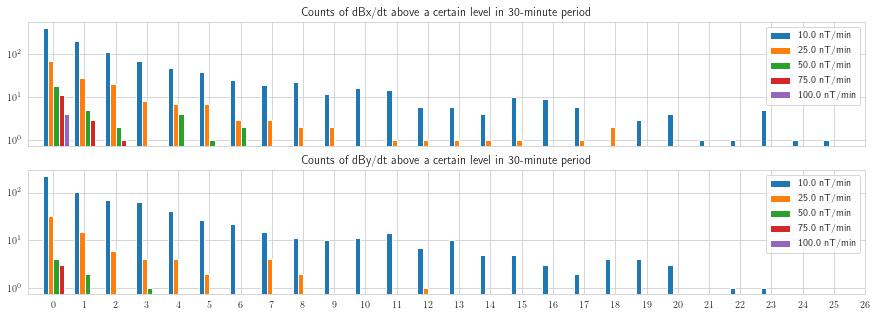

In [37]:
x = np.arange(30)
width = 0.17
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5), sharex=True)
for i_val, dbdt_val in enumerate([10., 25., 50., 75., 100.]):
    adjust_bar = width*i_val - 0.25
    ax1.bar(x+adjust_bar, dbdt_counts_x[dbdt_val], width, label=str(dbdt_val)+' nT/min')
    ax2.bar(x+adjust_bar, dbdt_counts_y[dbdt_val], width, label=str(dbdt_val)+' nT/min')
ax1.set_title("Counts of dBx/dt above a certain level in 30-minute period".format(dbdt_val))
ax2.set_title("Counts of dBy/dt above a certain level in 30-minute period".format(dbdt_val))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax1.set_xticks(x)
ax2.set_xticks(x)
ax1.set_xlim(-0.8, 26)
plt.show()

## 3. Case Study: 2003 Halloween Storm

Study of the 2003 Halloween storm using FUR data.

### Plot the 2003 Halloween storm

In [51]:
# Prepare data
hs_start, hs_end = datetime(2003,10,29), datetime(2003,11,1)
halloween_storm = df_FUR[hs_start:hs_end-timedelta(minutes=1)]
gic_2003_SS1 = sw2gic.extract_time_from_pos(gic_fit_SS1, hs_start, hs_end)
gic_2003_SS2 = sw2gic.extract_time_from_pos(gic_fit_SS2, hs_start, hs_end)

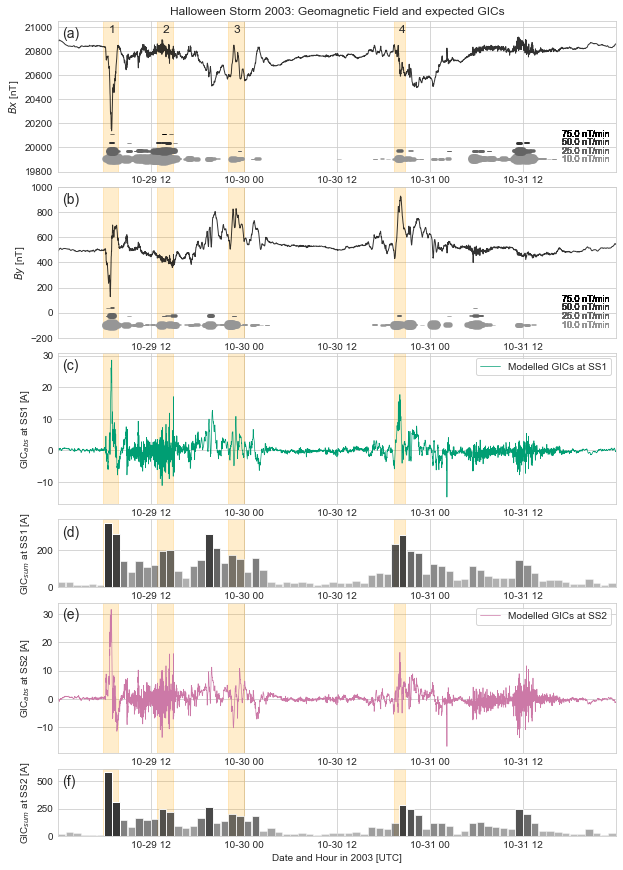

In [63]:
import matplotlib.gridspec as gridspec
import matplotlib
#matplotlib.rc('text', usetex=True)
matplotlib.rc('text', usetex=False)

sns.set_style("whitegrid")
lw_hs = 0.7

periods_of_interest = [ [datetime(2003,10,29,5,50), datetime(2003,10,29,7,50)], 
                        [datetime(2003,10,29,12,50), datetime(2003,10,29,14,50)], 
                        [datetime(2003,10,29,22,0), datetime(2003,10,30,0)],
                        [datetime(2003,10,30,19,20), datetime(2003,10,30,20,50)]]

fig = plt.figure(constrained_layout=False, figsize=(10, 15))
gs = fig.add_gridspec(10, 1)
ax1 = fig.add_subplot(gs[0:2, 0])
ax12 = fig.add_subplot(gs[2:4, 0], sharex=ax1)
ax2 = fig.add_subplot(gs[4:6, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[6, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[7:9, 0], sharex=ax1)
ax5 = fig.add_subplot(gs[9, 0], sharex=ax1)

# Plot geomagnetic field variations
ax1.plot_date(halloween_storm.index, halloween_storm['Bx'], 'k-', lw=lw_hs*1.4, alpha=0.8)
ax12.plot_date(halloween_storm.index, halloween_storm['By'], 'k-', lw=lw_hs*1.4, alpha=0.8)
ax1.set_ylim(19800, 21050)
ax1.set_xlim([hs_start+timedelta(minutes=1), hs_end-timedelta(minutes=1)])
ax12.set_ylim(-200, 1000)

# Plot presence of levels of dB/dt:
yoff_levels = 70 # 50
xoff_levels = datetime(2003,10,31,17) #datetime(2003,10,29,0,30)
level_plot = {75: yoff_levels*3, 50: yoff_levels*2, 25: yoff_levels, 10: 0}
c_plot = {75: 0, 50: 50./255., 25: 100./255., 10: 150./255.}
for x in range(1,30):
    for dbdt_val in [75., 50., 25., 10.]:
        for ax, y_base, db_counts in zip([ax1, ax12], [19900, -100], [dbdt_counts_dates_x, dbdt_counts_dates_y]):
            # Label the levels:
            ax.text(xoff_levels, y_base+level_plot[dbdt_val]-20, "{} nT/min".format(dbdt_val), 
                    fontsize=9, color=(c_plot[dbdt_val],c_plot[dbdt_val],c_plot[dbdt_val], 1))
            for t_above_level in db_counts[dbdt_val][x]:
                if np.logical_and(t_above_level < hs_end, t_above_level > hs_start):
                    ax.plot_date([t_above_level, t_above_level+timedelta(minutes=test_range_after)], 
                                 [y_base+level_plot[dbdt_val], y_base+level_plot[dbdt_val]],
                                 '-', c=(c_plot[dbdt_val],c_plot[dbdt_val],c_plot[dbdt_val], 1), 
                                 lw=x/2., zorder=dbdt_val)
                
# Plot GICs
ax2.plot_date(halloween_storm.index, gic_2003_SS1, '-', c=c_SS1, lw=lw_hs, label="Modelled GICs at SS1")
ax2.legend()
ax4.plot_date(halloween_storm.index, gic_2003_SS2, '-', c=c_SS2, lw=lw_hs, label="Modelled GICs at SS2")
ax4.legend()

# Highlight areas of interest:
for i_tb, t_bounds in enumerate(periods_of_interest):
    ax1.text(t_bounds[0]+timedelta(hours=0.7), 20950, str(i_tb+1), fontsize=12)
    for i_ax, ax in enumerate([ax1, ax12, ax2, ax3, ax4, ax5]):
        ax.axvspan(t_bounds[0], t_bounds[1], alpha=0.2, color='orange')
        
# Label each panel:
for ax, ann in zip([ax1, ax12, ax2, ax4], ['a', 'b', 'c', 'e']): # large axes
    ax.text(0.007, 0.89, "({})".format(ann), transform=ax.transAxes, fontsize=14)
for ax, ann in zip([ax3, ax5], ['d', 'f']): # small axes
    ax.text(0.007, 0.75, "({})".format(ann), transform=ax.transAxes, fontsize=14)

# Plot the cumulative sums:
color_step = 10
low_alpha = 0.3
event_inds = np.where(np.logical_and(t_sums >= hs_start, t_sums < hs_end))
gic_SS1_sums_event = gic_SS1_sums[event_inds]
gic_SS2_sums_event = gic_SS2_sums[event_inds]
t_sums_event = t_sums[event_inds]
c_sums = '#363636'
bar_width = 4e-2
for i_bars in range(0, int(gic_SS1_sums_event.max())+color_step, color_step):
    inds = np.logical_and(gic_SS1_sums_event >= i_bars, gic_SS1_sums_event < i_bars + color_step)
    ax3.bar(t_sums_event[inds], gic_SS1_sums_event[inds], width=bar_width, fc=c_sums, alpha=np.min([low_alpha+i_bars/300.*(1.0-low_alpha),1]))
for i_bars in range(0, int(gic_SS2_sums_event.max())+color_step, color_step):
    inds = np.logical_and(gic_SS2_sums_event >= i_bars, gic_SS2_sums_event < i_bars + color_step)
    ax5.bar(t_sums_event[inds], gic_SS2_sums_event[inds], width=bar_width, fc=c_sums, alpha=np.min([low_alpha+i_bars/300.*(1.0-low_alpha),1]))
    
for ax in [ax1, ax12, ax2, ax3, ax4, ax5]:
    ax.tick_params(axis='y', pad=1)
    ax.tick_params(axis='x', pad=1)

ax1.set_title("Halloween Storm 2003: Geomagnetic Field and expected GICs")
ax1.set_ylabel(r"$Bx$ [nT]")
ax12.set_ylabel(r"$By$ [nT]")
ax2.set_ylabel(r"GIC$_{abs}$ at SS1 [A]")
ax3.set_ylabel(r"GIC$_{sum}$ at SS1 [A]")
ax4.set_ylabel(r"GIC$_{abs}$ at SS2 [A]")
ax5.set_ylabel(r"GIC$_{sum}$ at SS2 [A]")
ax5.set_xlabel("Date and Hour in 2003 [UTC]")
plt.subplots_adjust(hspace=0.23)
plt.savefig(os.path.join(plot_path, "halloween.png"), dpi=300, bbox_inches='tight')
plt.show()

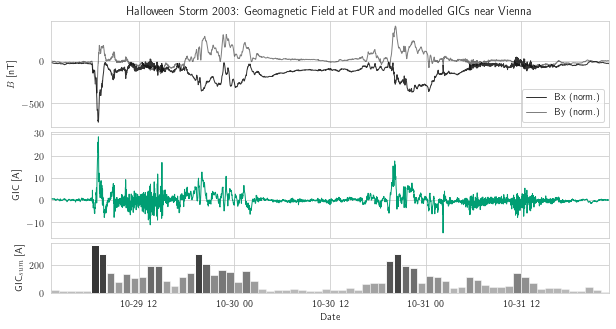

In [30]:
# Reduced plot:
matplotlib.rc('text', usetex=True)
fig = plt.figure(constrained_layout=False, figsize=(10, 5))
gs = fig.add_gridspec(5, 1)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[4, 0], sharex=ax1)

# Plot geomagnetic field
ax1.plot_date(halloween_storm.index, halloween_storm['Bx'] - halloween_storm['Bx'][:100].mean(), 'k-', 
              lw=1, alpha=0.8, label="Bx (norm.)")
ax1.plot_date(halloween_storm.index, halloween_storm['By'] - halloween_storm['By'][:100].mean(), 'k-', 
              lw=1, alpha=0.5, label="By (norm.)")
ax1.set_xlim([hs_start+timedelta(hours=1), hs_end-timedelta(hours=1)])
ax1.legend()
                
# Plot GICs
ax2.plot_date(halloween_storm.index, gic_2003_SS1, '-', lw=1, c=c_SS1)

# Plot the cumulative sum:
color_step = 10
low_alpha = 0.3
# Set a time axis. Bars with time as x-axis throw an error without this
ax3.plot_date([halloween_storm.index[0], halloween_storm.index[-1]], [0.,0.], c='white', lw=0.)
for i_bars in range (0, int(gic_SS1_sums_event.max())+color_step, color_step):
    inds = np.logical_and(gic_SS1_sums_event >= i_bars, gic_SS1_sums_event < i_bars + color_step)
    ax3.bar(t_sums_event[inds], gic_SS1_sums_event[inds], width=bar_width, fc=c_sums, alpha=np.min([low_alpha+i_bars/300.*(1.0-low_alpha),1]))
    
ax1.set_title("Halloween Storm 2003: Geomagnetic Field at FUR and modelled GICs near Vienna")
ax1.set_ylabel(r"$B$ [nT]")
ax2.set_ylabel(r"GIC [A]")
ax3.set_ylabel(r"GIC$_{sum}$ [A]")
ax3.set_xlabel("Date % Time (UTC)")
plt.subplots_adjust(hspace=0.1)
plt.savefig(os.path.join(plot_path, "halloween_reduced.png"), dpi=300, bbox_inches='tight')
plt.show()

### Plot the days that have large prolonged GICs only

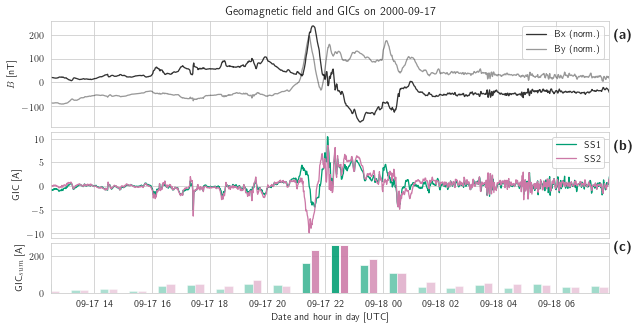

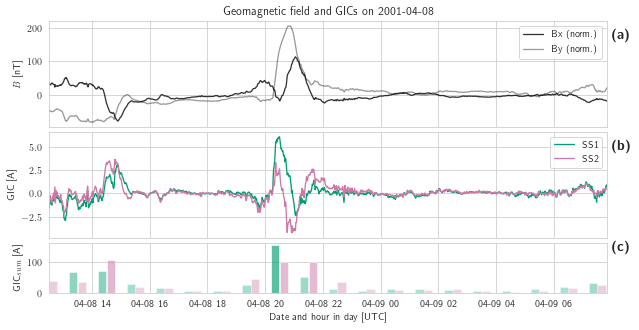

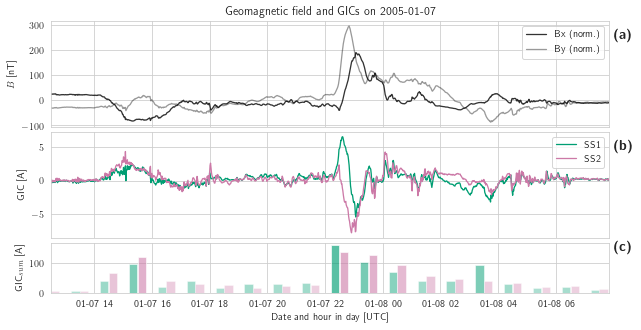

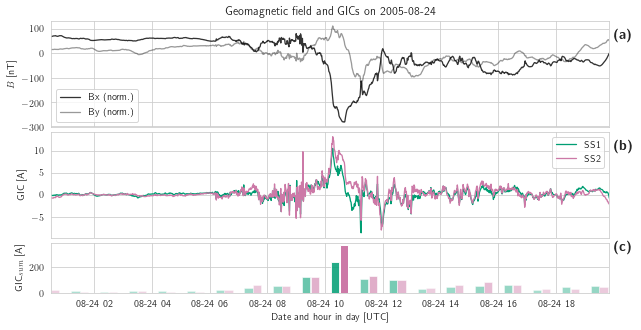

In [31]:
lw = 1.3
alpha_SS1, alpha_SS2 = 1, 1.
for test_day in ['2000-09-17T21:00', '2001-04-08T21:00', '2005-01-07T21:00', '2005-08-24T09:00']:
    test_date = datetime.strptime(test_day, "%Y-%m-%dT%H:%M") - timedelta(hours=12)
    plot_offset = timedelta(hours=24)
    time_plot = df_FUR[test_date:test_date+plot_offset].index[:-1]
    Bx_plot = df_FUR[test_date:test_date+plot_offset]['Bx'][:-1]
    By_plot = df_FUR[test_date:test_date+plot_offset]['By'][:-1]
    n_min_diff = int((test_date - zero_time).total_seconds()/60.)
    
    # Reduced plot:
    matplotlib.rc('text', usetex=True)
    fig = plt.figure(constrained_layout=False, figsize=(10, 5))
    gs = fig.add_gridspec(5, 1)
    ax1 = fig.add_subplot(gs[0:2, 0])
    ax2 = fig.add_subplot(gs[2:4, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[4, 0], sharex=ax1)

    # Plot geomagnetic field
    ax1.plot_date(time_plot, Bx_plot - Bx_plot.mean(), 'k-', lw=lw, alpha=0.8, label="Bx (norm.)")
    ax1.plot_date(time_plot, By_plot - By_plot.mean(), 'k-', lw=lw, alpha=0.4, label="By (norm.)")
    ax1.legend()

    # Plot GICs
    ax2.plot_date(time_plot, gic_fit_SS1[n_min_diff:n_min_diff+n_mins_day], '-', c=c_SS1, lw=lw, label="SS1", alpha=alpha_SS1)
    ax2.plot_date(time_plot, gic_fit_SS2[n_min_diff:n_min_diff+n_mins_day], '-', c=c_SS2, lw=lw, label="SS2", alpha=alpha_SS2)
    ax2.legend()
        
    # Calculate the cumulative sum over half hour periods:
    window_len = 60
    cut1, cut2 = n_min_diff, n_min_diff + window_len
    t_sums_date, gic_SS1_sums_date, gic_SS2_sums_date = [], [], []
    while (cut2-n_min_diff) < 60*24:
        cut2 = cut1 + window_len
        t_sums_date.append(test_date + timedelta(minutes=cut1-n_min_diff+window_len/2))
        gic_SS1_sums_date.append(np.sum(np.abs(gic_fit_SS1[cut1:cut2])))
        gic_SS2_sums_date.append(np.sum(np.abs(gic_fit_SS2[cut1:cut2])))
        cut1 += window_len
    t_sums_date, gic_SS1_sums_date, gic_SS2_sums_date = np.array(t_sums_date), np.array(gic_SS1_sums_date), np.array(gic_SS2_sums_date)
    
    # Plot the cumulative sum:
    color_step = 10
    low_alpha = 0.3
    # Set a time axis. Bars with time as x-axis throw an error without this
    ax3.plot_date([time_plot[0], time_plot[-1]], [0.,0.], c='white', lw=0.)
    for i_bars in range(0, int(np.max(gic_SS1_sums_date))+color_step, color_step):
        inds = np.logical_and(gic_SS1_sums_date >= i_bars, gic_SS1_sums_date < i_bars + color_step)
        ax3.bar(t_sums_date[inds]-timedelta(minutes=9), gic_SS1_sums_date[inds], width=1.2e-2, fc=c_SS1, alpha=np.min([low_alpha+i_bars/300.*(1.0-low_alpha),1]))
    for i_bars in range(0, int(np.max(gic_SS2_sums_date))+color_step, color_step):
        inds = np.logical_and(gic_SS2_sums_date >= i_bars, gic_SS2_sums_date < i_bars + color_step)
        ax3.bar(t_sums_date[inds]+timedelta(minutes=9), gic_SS2_sums_date[inds], width=1.2e-2, fc=c_SS2, alpha=np.min([low_alpha+i_bars/300.*(1.0-low_alpha),1]))

    ax1.set_xlim((test_date+timedelta(minutes=30)+timedelta(hours=3), test_date+timedelta(days=1)-timedelta(minutes=70)))
    ax1.set_title("Geomagnetic field and GICs on {}".format(test_day[:10]))
    ax1.set_ylabel(r"$B$ [nT]")
    ax2.set_ylabel(r"GIC [A]")
    ax3.set_ylabel(r"GIC$_{sum}$ [A]")
    ax3.set_xlabel("Date and hour in day [UTC]")
    plt.subplots_adjust(hspace=0.1)
    
    # Label each panel:
    for ax, ann in zip([ax1, ax2, ax3], ['a', 'b', 'c']):
        ax.text(1.01, 0.83, r"$\textbf{("+ann+")}$", transform=ax.transAxes, fontsize=14, weight='bold')
    
    plt.savefig(os.path.join(plot_path, "example_{}.png".format(test_day[:10])), dpi=300, bbox_inches='tight')
    plt.show()